In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/question-pairs-dataset/questions.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk , string

import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

nltk.download('wordnet')

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')

In [4]:
df.shape

(404351, 6)

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.drop('id',axis=1,inplace=True)

In [7]:
df['is_duplicate'].value_counts(normalize=True)

is_duplicate
0    0.630752
1    0.369248
Name: proportion, dtype: float64

In [8]:
df['is_duplicate'].value_counts()

is_duplicate
0    255045
1    149306
Name: count, dtype: int64

<Axes: xlabel='is_duplicate'>

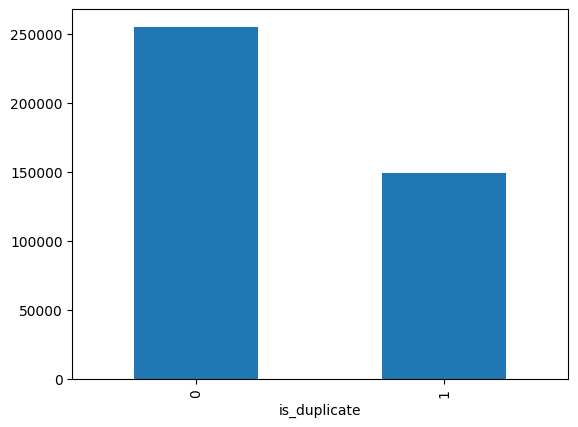

In [9]:
df['is_duplicate'].value_counts().plot(kind='bar')

**The dataset is imbalanced**  
But as the adatset is large , we can handle this by splitting dataset in a stratified fashion

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404351 non-null  int64 
 1   qid2          404351 non-null  int64 
 2   question1     404350 non-null  object
 3   question2     404349 non-null  object
 4   is_duplicate  404351 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.4+ MB


In [11]:
df.isnull().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [14]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions : ',np.unique(qid).shape[0])
x = qid.duplicated()
print('Number of questions getting repeated : ',x.sum())

Number of unique questions :  789795
Number of questions getting repeated :  18901


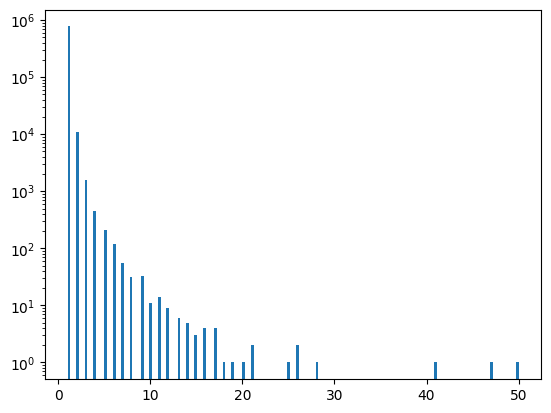

In [15]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [16]:
df.sample(20)

,qid1,qid2,question1,question2,is_duplicate
49425,98387,98388,What is your favourite movie and why?,Favourite movie of all time? Why?,1
192169,379372,379373,What are the best looking tanks?,What would a tank designed for purely urban wa...,0
298855,586996,586997,What do Delhiites feel about AAP?,How do people in Delhi feel about the AAP?,1
312081,612569,612570,How and when ISS was send to space?,How was ISS sent to space?,1
363123,710878,710879,"If I walk or run 2 miles a day, will I lose we...",How much weight can I lose in 1 month if I run...,0
372237,728358,728359,Do I need to get NOC from Kolkata if I need to...,Do I need to get NOC from Kolkata if I need to...,1
157768,311984,311985,When can we expect APPSC Group-I/II notification?,What is the ratio for APPSC AE notification?,0
349982,685648,685649,Is it possible to score 99.5+ percentile on CAT?,Is it possible to score 99 percentile in CAT?,0
208432,411162,411163,Has anyone (preferably female) recovered from ...,What is the perfect way to layer a burger?,0
334202,655274,655275,Why is sugar soluble in water?,Why is starch soluble in water?,0


### Steps for going ahead with the data :

1. Preprocessing
    * Remove Punctuation
    * Remove stopwords
    * Remoe 


In [17]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [ ]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [ ]:
df.head(20)

In [ ]:
df['q1_len'] = df['question1'].apply(lambda x : len(x.split()))
df['q2_len'] = df['question2'].apply(lambda x : len(x.split()))

In [ ]:
df['q1_num_words'] = df['question1'].apply(lambda x : len(x.split(' ')))
df['q2_num_words'] = df['question2'].apply(lambda x : len(x.split(' ')))

In [ ]:
def common_words(row):
    
    w1 = set(row['question1'].split(' '))
    w2 = set(row['question2'].split(' '))
    
    return len(w1 & w2)
    

In [ ]:
df['common_words'] = df.apply(common_words, axis=1)

In [ ]:
df.head(10)

In [ ]:
def total_words(row):
    
    w1 = len(row['question1'].split(' '))
    w2 = len(row['question2'].split(' '))
    
    return w1 + w2

In [ ]:
df['total_words'] = df.apply(total_words, axis=1)

In [ ]:
df['word_share'] = round(df['common_words']/df['total_words'],2)

In [ ]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = stopwords.words('english')
    
    token_features = [0.0] * 8
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0 :
        return token_features
    
    # Non stopwords
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Stopwords
    
    q1_stopwords = set([word for word in q1_tokens if word  in STOP_WORDS])
    q2_stopwords = set([word for word in q2_tokens if word  in STOP_WORDS])
    
    
    # Common Word Count
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Common Stopword Count
    
    common_stopword_count = len(q1_stopwords.intersection(q2_stopwords))
    
    # Get the common Tokens from Question pair
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words) , len(q2_words))+ SAFE_DIV) 
    token_features[1] = common_word_count / (max(len(q1_words) , len(q2_words))+ SAFE_DIV)
    token_features[2] = common_stopword_count / (min(len(q1_stopwords) , len(q2_stopwords))+ SAFE_DIV)
    token_features[3] = common_stopword_count / (max(len(q1_stopwords) , len(q2_stopwords))+ SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens) , len(q2_tokens))+ SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens) , len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    
    return token_features
    
    
    

In [ ]:
token_features = df.apply(fetch_token_features,axis=1)

df['cwc_min'] = list(map(lambda x : x[0] , token_features))
df['cwc_max'] = list(map(lambda x : x[1] , token_features))
df['csc_min'] = list(map(lambda x : x[2] , token_features))
df['csc_max'] = list(map(lambda x : x[3] , token_features))
df['ctc_min'] = list(map(lambda x : x[4] , token_features))
df['ctc_max'] = list(map(lambda x : x[5] , token_features))
df['last_word_eq'] = list(map(lambda x : x[6] , token_features))
df['first_word_eq'] = list(map(lambda x : x[7] , token_features))

In [ ]:
df.head()

In [ ]:
! pip install Distance

In [ ]:

import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1) if strs else 0
    
    return length_features
    

In [ ]:

length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [ ]:
df.head()

In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [ ]:
df.head()

In [ ]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

In [ ]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

In [ ]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

In [ ]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
ques_df = df[['question1','question2']]
ques_df.head()

In [ ]:

final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000,)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

In [ ]:

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

In [ ]:

from sklearn.metrics import confusion_matrix

In [ ]:

# for random forest model
confusion_matrix(y_test,y_pred)

In [ ]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

In [ ]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(common_words(q1,q2))
    input_query.append(total_words(q1,q2))
    input_query.append(round(common_words(q1,q2)/total_words(q1,q2),2))
    
    # fetch token features
    token_features = fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [ ]:

q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [ ]:

rf.predict(query_point_creator(q1,q4))

In [ ]:

import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))